In [1]:
import torch
import torch.nn as nn
from AudioDataset import AudioDataset
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device for GPU acceleration.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for GPU acceleration.")
else:
    device = torch.device("cpu")
    print("No GPU device found. Using CPU.")

Using CUDA device for GPU acceleration.


In [3]:
import random

random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [43]:
class AudioTransformer(nn.Module):
    def __init__(self, n_mels=80, n_classes=12, d_model=64, nhead=2, num_layers=1, dim_feedforward=128):
        super(AudioTransformer, self).__init__()
        self.input_proj = nn.Linear(n_mels, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(d_model, n_classes)

    def forward(self, x):
        x = self.input_proj(x)
        transformer_out = self.transformer_encoder(x)
        x = transformer_out.mean(dim=1)
        out = self.classifier(x)
        return out

In [63]:
dataset = AudioDataset(
    csv_path="./data/train.csv",
    audio_dir="./data_raw/train/audio"
)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True)

In [65]:
model = AudioTransformer(n_mels=80, n_classes=12)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [66]:
model = model.to(device)

In [68]:
for epoch in range(3):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f'{i+1}/{len(dataloader)}')

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(dataloader):.4f}")

1/202
2/202
3/202
4/202
5/202
6/202
7/202
8/202
9/202
10/202
11/202
12/202
13/202
14/202
15/202
16/202
17/202
18/202
19/202
20/202
21/202
22/202
23/202
24/202
25/202
26/202
27/202
28/202
29/202
30/202
31/202
32/202
33/202
34/202
35/202
36/202
37/202
38/202
39/202
40/202
41/202
42/202
43/202
44/202
45/202
46/202
47/202
48/202
49/202
50/202
51/202
52/202
53/202
54/202
55/202
56/202
57/202
58/202
59/202
60/202
61/202
62/202
63/202
64/202
65/202
66/202
67/202
68/202
69/202
70/202
71/202
72/202
73/202
74/202
75/202
76/202
77/202
78/202
79/202
80/202
81/202
82/202
83/202
84/202
85/202
86/202
87/202
88/202
89/202
90/202
91/202
92/202
93/202
94/202
95/202
96/202
97/202
98/202
99/202
100/202
101/202
102/202
103/202
104/202
105/202
106/202
107/202
108/202
109/202
110/202
111/202
112/202
113/202
114/202
115/202
116/202
117/202
118/202
119/202
120/202
121/202
122/202
123/202
124/202
125/202
126/202
127/202
128/202
129/202
130/202
131/202
132/202
133/202
134/202
135/202
136/202
137/202
138/202
139/

In [69]:
dataset = AudioDataset(
    csv_path="./data/test.csv",
    audio_dir="./data_raw/train/audio"
)
test_loader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True)

Accuracy of the network: 62.00%
Accuracy of class "yes": 0.00%
Accuracy of class "no": 0.00%
Accuracy of class "up": 0.00%
Accuracy of class "down": 0.00%
Accuracy of class "left": 0.00%
Accuracy of class "right": 0.00%
Accuracy of class "on": 0.00%
Accuracy of class "off": 0.00%
Accuracy of class "stop": 0.00%
Accuracy of class "go": 0.00%
Accuracy of class "unknown": 0.00%
Accuracy of class "silence": 100.00%


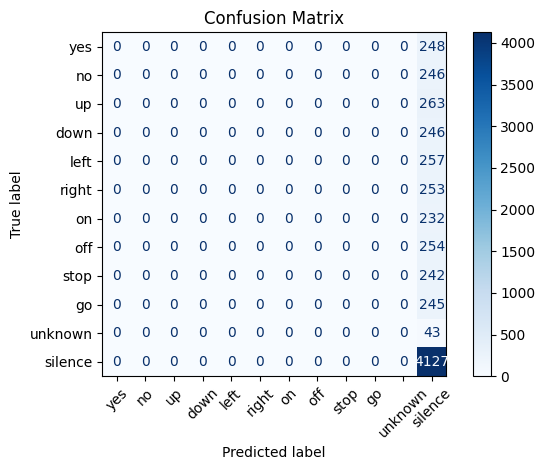

In [70]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



model.eval() 
classes = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "unknown", "silence"]
all_preds = []
all_labels = []

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for _ in range(12)]
    n_class_samples = [0 for _ in range(12)]

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1

acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network: {acc:.2f}%')

for i in range(12):
    class_acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of class "{classes[i]}": {class_acc:.2f}%')


cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()